## Configuration Spark

In [ ]:
import socket

def check_port(host, port):
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    sock.settimeout(5)  # Timeout de 5 secondes
    result = sock.connect_ex((host, port))
    if result == 0:
        print(f"Connexion réussie à {host}:{port}")
    else:
        print(f"Impossible de se connecter à {host}:{port}")
    sock.close()

check_port("kafka1", 9092)


Connexion réussie à kafka1:9092


In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext

conf = SparkConf() \
    .setAppName('SparkApp') \
    .setMaster('spark://spark:7077') \
    .set("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.3.4,org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.3") \
    .set("spark.sql.shuffle.partitions", "10")
 

sc = SparkContext.getOrCreate(conf=conf)


# Créer un SQLContext pour les opérations SQL
sql_context = SQLContext(sc)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/jovyan/.ivy2/cache
The jars for the packages stored in: /home/jovyan/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-3a73fb42-2da9-4843-9113-83d2ac2e758d;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.4 in central
	found com.amazonaws#aws-java-sdk-bundle;1.12.262 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.3 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.3 in central
	found org.apache.kafka#kafka-clients;3.4.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.5 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	

## Imports

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col, count, window, avg, to_timestamp, min, max, last, broadcast, current_timestamp
from pyspark.sql.functions import sum as spark_sum
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType, DoubleType, BooleanType

## Schémas et Topics


In [4]:
kafka_broker = "kafka1:9092"
arrets_topic = "arrets"
velos_topic = "velos"
relais_topic = "relais"

# Définition du schéma pour le topic "arrets"
schema_arrets = StructType([
    StructField("codeLieu", StringType()),
    StructField("libelle", StringType()),
    StructField("distance", FloatType()),
    StructField("ligne", StringType())
])

# Définition du schéma pour le champ "position"
position_schema = StructType([
    StructField("lon", DoubleType()),
    StructField("lat", DoubleType())
])

# Définition du schéma pour le topic "velos"
schema_velos = StructType([
    StructField("number", StringType()),
    StructField("name", StringType()),
    StructField("address", StringType()),
    StructField("position", position_schema),
    StructField("banking", StringType()),
    StructField("bonus", StringType()),
    StructField("status", StringType()),
    StructField("contract_name", StringType()),
    StructField("bike_stands", IntegerType()),
    StructField("available_bike_stands", IntegerType()),
    StructField("available_bikes", IntegerType()),
    StructField("last_update", StringType())
])

# Définition du schéma pour le topic "relais"
schema_relais = StructType([
    StructField("grp_identifiant", StringType()),
    StructField("grp_nom", StringType()),
    StructField("grp_statut", IntegerType()),
    StructField("grp_disponible", IntegerType()),
    StructField("grp_exploitation", IntegerType()),
    StructField("grp_complet", IntegerType()),
    StructField("grp_horodatage", StringType()),
    StructField("idobj", StringType()),
    StructField("location", StructType([
        StructField("lon", DoubleType()),
        StructField("lat", DoubleType())
    ])),
    StructField("disponibilite", DoubleType())
])

# Définition du schéma pour le topic "relais"
schema_parking_public = StructType([
    StructField("grp_identifiant", StringType(), True),
    StructField("grp_nom", StringType(), True),
    StructField("grp_statut", StringType(), True),
    StructField("grp_disponible", IntegerType(), True),
    StructField("grp_exploitation", IntegerType(), True),
    StructField("grp_complet", IntegerType(), True),
    StructField("grp_horodatage", StringType(), True),
    StructField("idobj", StringType(), True),
    StructField("location", StructType([
         StructField("lon", DoubleType(), True),
         StructField("lat", DoubleType(), True)
    ]), True)
])

## Requête Batch sans fenêtre

Comptage des arrêts par ligne à partir du topic « arrets »

In [5]:
# Lecture brute des messages Kafka
df_kafka = sql_context.read \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafka_broker) \
    .option("subscribe", arrets_topic) \
    .option("startingOffsets", "earliest") \
    .load()

# Conversion du champ "value" (encodé en JSON) en colonnes structurées
df_arrets = df_kafka.selectExpr("CAST(value AS STRING) AS message") \
    .select(from_json(col("message"), schema_arrets).alias("data")) \
    .select("data.*")

# Agrégation : compter le nombre d'arrêts par "ligne"
result = df_arrets.groupBy("ligne").agg(count("*").alias("nb_arrets"))

# Affichage du résultat
result.show()
result.describe().show()

25/02/19 18:44:04 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+--------------------+---------+
|               ligne|nb_arrets|
+--------------------+---------+
|[{"numLigne":"105...|        4|
| [{"numLigne":"30"}]|       12|
|[{"numLigne":"127...|        2|
|[{"numLigne":"10"...|        1|
|[{"numLigne":"119...|        7|
|[{"numLigne":"50"...|        4|
| [{"numLigne":"91"}]|       14|
|[{"numLigne":"11"...|        4|
|[{"numLigne":"101...|        2|
| [{"numLigne":"80"}]|       10|
|[{"numLigne":"2B"...|        1|
|[{"numLigne":"152...|        1|
|[{"numLigne":"59"...|        3|
| [{"numLigne":"C3"}]|       12|
|[{"numLigne":"28"...|        1|
|[{"numLigne":"30"...|        7|
|[{"numLigne":"109...|        1|
|[{"numLigne":"104...|        1|
| [{"numLigne":"79"}]|        6|
|[{"numLigne":"102...|        3|
+--------------------+---------+
only showing top 20 rows



25/02/19 18:44:09 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+-------+--------------------+-----------------+
|summary|               ligne|        nb_arrets|
+-------+--------------------+-----------------+
|  count|                 434|              434|
|   mean|                NULL|2.686635944700461|
| stddev|                NULL|3.224968441931372|
|    min|                  []|                1|
|    max|[{"numLigne":"NBI"}]|               28|
+-------+--------------------+-----------------+



Analyse des stations de vélo par statut historique

In [6]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql import Window

spark = SparkSession.builder.appName("BikeHistory").getOrCreate()

# --- Helper function: read_kafka_stream ---
def read_kafka_stream(topic, schema, is_streaming=True):
    if is_streaming:
        df = spark.readStream.format("kafka") \
            .option("kafka.bootstrap.servers", kafka_broker) \
            .option("subscribe", topic) \
            .option("startingOffsets", "earliest") \
            .load()
    else:
        df = spark.read.format("kafka") \
            .option("kafka.bootstrap.servers", kafka_broker) \
            .option("subscribe", topic) \
            .option("startingOffsets", "earliest") \
            .load()
    # Convert the binary "value" column to string and parse JSON using the provided schema.
    df = df.selectExpr("CAST(value AS STRING) as json_string")
    df = df.select(F.from_json(F.col("json_string"), schema).alias("data")).select("data.*")
    return df

# Read batch data from the "velos" topic (is_streaming=False)
df_velos = read_kafka_stream("velos", schema_velos, is_streaming=False).where(F.col("status").isNotNull())

# Perform aggregation by 'status'
result_batch1 = df_velos.groupBy("status") \
    .agg(
        F.count("*").alias("total_stations"),
        F.avg("available_bikes").alias("moyenne_velos_dispos"),
        F.stddev("available_bikes").alias("ecart_type_velos")
    ) \
    .withColumn("pourcentage", F.col("total_stations") / F.sum("total_stations").over(Window.partitionBy())) \
    .orderBy(F.desc("total_stations"))

result_batch1.show()


25/02/19 18:44:14 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
25/02/19 18:44:15 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 18:44:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/19 18:44:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/19 18:44:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/19 18:44:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/19 18:44:16 WARN 

+------+--------------+--------------------+-----------------+-----------+
|status|total_stations|moyenne_velos_dispos| ecart_type_velos|pourcentage|
+------+--------------+--------------------+-----------------+-----------+
|  OPEN|          1764|    8.28061224489796|6.202029608458418|       0.98|
|CLOSED|            36|                 0.0|              0.0|       0.02|
+------+--------------+--------------------+-----------------+-----------+



## Requête Batch avec fenêtre

Vélos disponibles par contrat sur des fenêtres temporelles à partir du topic « velos ».
Malheuresement on a qu'une donnée par station donc ca permet pas de faire de l'aggrégation comme la moyenne de vélo sur la période..... faut essayer de trouver des données plus pertinentes.

In [7]:
# Lecture brute des messages Kafka
df_kafka = sql_context.read \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafka_broker) \
    .option("subscribe", velos_topic) \
    .option("startingOffsets", "earliest") \
    .load()

# Conversion du champ "value" en JSON
df_velos = df_kafka.selectExpr("CAST(value AS STRING) AS message") \
    .select(from_json(col("message"), schema_velos).alias("data")) \
    .select("data.*")

# Conversion de "last_update" en timestamp (format ISO 8601)
df_velos = df_velos.withColumn("last_update_ts", 
                               to_timestamp(col("last_update"), "yyyy-MM-dd'T'HH:mm:ssXXX"))

# Agrégation par fenêtre (ici, on allonge la fenêtre à 30 minutes pour accumuler plusieurs mises à jour) et par station
result_window = df_velos.groupBy(
    window(col("last_update_ts"), "30 minutes"), 
    col("number"),
    col("contract_name")
).agg(
    count("*").alias("nb_updates"),
    last("available_bikes", ignorenulls=True).alias("latest_available_bikes")
)

result_window.show()

## Requête Batch avec visualisation

Graphique des totaux de stations par statut avec Pandas et Seaborn

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the Spark DataFrame to Pandas for visualization
pdf = result_batch1.toPandas()

plt.figure(figsize=(10,6))
sns.barplot(data=pdf, x="status", y="total_stations", palette="viridis")
plt.title("Total des stations de vélo par statut")
plt.xlabel("Statut")
plt.ylabel("Nombre total de stations")
plt.show()


## Requêtes Streaming

### Récuperer la moyenne des disponiblités des parkings relais sur une fenêtre glissante.

In [ ]:
# Lecture en streaming depuis Kafka
df_kafka = sql_context.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafka_broker) \
    .option("subscribe", relais_topic) \
    .option("startingOffsets", "latest") \
    .load()

# Conversion du champ "value" (JSON) en colonnes structurées
df_relais = df_kafka.selectExpr("CAST(value AS STRING) AS message") \
    .select(from_json(col("message"), schema_relais).alias("data")) \
    .select("data.*")

# Conversion du champ "grp_horodatage" en timestamp
# Le format ISO 8601 est utilisé : "yyyy-MM-dd'T'HH:mm:ssXXX"
df_relais = df_relais.withColumn("horodatage_ts", 
                                  to_timestamp(col("grp_horodatage"), "yyyy-MM-dd'T'HH:mm:ssXXX"))

# Définition d'un watermark de 5 minutes pour gérer les retards éventuels
df_relais = df_relais.withWatermark("horodatage_ts", "5 minutes")

# Agrégation : calcul de la moyenne des disponibilités sur une fenêtre glissante
# Ici, la fenêtre est de 5 minutes et on agrège par "grp_identifiant"
result_stream = df_relais.groupBy(
    window(col("horodatage_ts"), "5 minutes"),
    col("grp_identifiant"),
).agg(
    avg("disponibilite").alias("avg_disponibilite")
)

# Écriture du résultat en streaming vers la console (mode "update")
query = result_stream.writeStream \
    .outputMode("update") \
    .format("console") \
    .option("truncate", "false") \
    .start()

query.awaitTermination()

In [ ]:
query.stop()

### Récuperer la moyenne des vélos disponibles par parking sur une fenêtre glissante.

In [ ]:
# Lecture en streaming depuis Kafka
df_kafka_velos = sql_context.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafka_broker) \
    .option("subscribe", velos_topic) \
    .option("startingOffsets", "latest") \
    .load()

# Conversion du champ "value" (JSON) en colonnes structurées
df_velos = df_kafka_velos.selectExpr("CAST(value AS STRING) AS message") \
    .select(from_json(col("message"), schema_velos).alias("data")) \
    .select("data.*")

# Conversion du champ "last_update" en timestamp (format ISO 8601)
df_velos = df_velos.withColumn("last_update_ts", 
                               to_timestamp(col("last_update"), "yyyy-MM-dd'T'HH:mm:ssXXX"))

# Application d'un watermark de 5 minutes pour gérer les retards
df_velos = df_velos.withWatermark("last_update_ts", "5 minutes")

# Agrégation sur une fenêtre de 5 minutes : calcul du total des places disponibles
result_velos = df_velos.groupBy(
    window(col("last_update_ts"), "5 minutes"),
    col("name")
).agg(
    avg("available_bikes").alias("moyenne_velos_disponibles")
)

# Écriture du résultat en streaming vers la console (mode "update")
query_velos = result_velos.writeStream \
    .outputMode("update") \
    .format("console") \
    .option("truncate", "false") \
    .start()

query_velos.awaitTermination()

In [ ]:
query_velos.stop()

## Multimodal query

Define the Haversine Function and UDF

In [7]:
from pyspark.sql import functions as F
from math import radians, sin, cos, sqrt, atan2

# 1. Define Python function
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    return 6371 * 2 * atan2(sqrt(a), sqrt(1-a))  # Earth radius in km

# 2. Create Spark UDF
haversine_udf = F.udf(haversine, DoubleType())

# 3. Register for SparkSQL
spark.udf.register("haversine", haversine_udf)

In [8]:
# 1. Read data and create temporary views
df_arrets = read_kafka_stream(arrets_topic, schema_arrets, is_streaming=False)
df_velos = read_kafka_stream(velos_topic, schema_velos, is_streaming=False)
df_relais = read_kafka_stream(relais_topic, schema_relais, is_streaming=False)
df_parking = read_kafka_stream("parking_public", schema_parking_public, is_streaming=False)

In [9]:
# Check record counts at each stage
print("Parking Count:", df_parking.count())  # Should be >0
print("Velos Count:", df_velos.count())      # Should be >0
print("Relais Count:", df_relais.count())    # Should be >0

# Check non-full parkings
non_full = df_parking.filter(F.col("grp_complet") != 1)
print("Non-Full Parkings:", non_full.count())

25/02/19 18:44:55 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


Parking Count: 522


25/02/19 18:44:55 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 18:44:56 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


Velos Count: 1800


25/02/19 18:44:57 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


Relais Count: 342
Non-Full Parkings: 522


Section 1: Batch Query – Aggregated Multimodal Connectivity Hubs

In [10]:
# Final Corrected Batch Request with Proper Syntax and Names
parking_bike_analysis = (
    df_parking.alias("parking")
    .filter(F.col("parking.grp_complet") != 1)
    .join(
        df_velos.alias("velo"),
        [
            (F.abs(F.col("parking.location.lon") - F.col("velo.position.lon")) <= 0.01),
            (F.abs(F.col("parking.location.lat") - F.col("velo.position.lat")) <= 0.01)
        ]
    )
    .withColumn("distance_km", haversine_udf(
        F.col("parking.location.lon"), 
        F.col("parking.location.lat"),
        F.col("velo.position.lon"),
        F.col("velo.position.lat")
    ))
    .filter(F.col("distance_km") <= 0.5)
    .groupBy("parking.grp_identifiant")
    .agg(
        F.avg("velo.available_bikes").alias("avg_bikes"),
        F.count_distinct("velo.number").alias("nearby_stations"),
        F.first("parking.location.lon").alias("parking_lon"),
        F.first("parking.location.lat").alias("parking_lat"),
        F.first("parking.grp_nom").alias("parking_grp_nom")  # Get parking's own name
    )
    .join(
        df_relais.alias("relais"), 
        "grp_identifiant", 
        "left"
    )
    .select(
        F.coalesce(
            "relais.grp_nom", 
            "parking_grp_nom", 
            F.concat(F.lit("Parking "), "grp_identifiant")
        ).alias("location_name"),  # Fixed parenthesis and alias position
        "avg_bikes",
        "nearby_stations",
        F.coalesce("relais.location.lon", "parking_lon").alias("lon"),
        F.coalesce("relais.location.lat", "parking_lat").alias("lat")
    )
)

parking_bike_analysis.show(truncate=False)

25/02/19 18:45:11 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 18:45:11 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 18:45:11 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+----------------------+------------------+---------------+-------------------+------------------+
|location_name         |avg_bikes         |nearby_stations|lon                |lat               |
+----------------------+------------------+---------------+-------------------+------------------+
|Feydeau               |7.150442477876106 |15             |-1.552558781000016 |47.21407529499999 |
|Decré-Bouffay         |6.845117845117845 |17             |-1.5540046290000191|47.21666261299998 |
|Tour Bretagne         |8.508361204013378 |18             |-1.5582500169999776|47.21784288800001 |
|Graslin               |9.959537572254336 |12             |-1.562571814000023 |47.214310205000004|
|Aristide Briand       |9.956284153005464 |12             |-1.5629364160000137|47.21709359800002 |
|Médiathèque           |8.752             |9              |-1.56233817399999  |47.210870821000015|
|Commerce              |8.536585365853659 |15             |-1.557713217000014 |47.21312028       |
|Talensac 

In [11]:
# Rank parking relays by nearby bike availability
parking_ranking = (
    read_kafka_stream(relais_topic, schema_relais, False).alias("relais")
    .crossJoin(read_kafka_stream(velos_topic, schema_velos, False).alias("velo"))
    .withColumn("distance_km", haversine_udf(
        F.col("relais.location.lon"),
        F.col("relais.location.lat"),
        F.col("velo.position.lon"),
        F.col("velo.position.lat")
    ))
    .filter(F.col("distance_km") <= 0.5)
    .groupBy("relais.grp_identifiant", "relais.grp_nom")
    .agg(
        F.avg("velo.available_bikes").alias("avg_bikes"),
        F.count_distinct("velo.number").alias("num_stations")
    )
    .withColumn("rank", 
               F.dense_rank().over(Window.orderBy(F.desc("avg_bikes")))
    )
    .orderBy("rank")
)

parking_ranking.show(truncate=False)

25/02/19 18:45:27 WARN ExtractPythonUDFFromJoinCondition: The join condition:(haversine(location#1148.lon, location#1148.lat, position#1181.lon, position#1181.lat)#1224 <= 0.5) of the join plan contains PythonUDF only, it will be moved out and the join plan will be turned to cross join.
25/02/19 18:45:27 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 18:45:27 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 18:45:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/19 18:45:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance d

+---------------+-------------+------------------+------------+----+
|grp_identifiant|grp_nom      |avg_bikes         |num_stations|rank|
+---------------+-------------+------------------+------------+----+
|140            |P+R Huit Mai |14.692307692307692|2           |1   |
|144            |P+R Gréneraie|7.6               |2           |2   |
+---------------+-------------+------------------+------------+----+



In [12]:
from pyspark.sql.window import Window

# Assume df_velos and df_relais are loaded in batch mode (is_streaming=False)

relays_velos = (
    df_relais.alias("rel")
    .join(
        df_velos.alias("vel"),
        haversine_udf(
            F.col("rel.location.lon"),
            F.col("rel.location.lat"),
            F.col("vel.position.lon"),
            F.col("vel.position.lat")
        ) <= 1.0  # 1 km threshold
    )
    .groupBy("rel.grp_identifiant", "rel.grp_nom")
    .agg(
         F.avg("vel.available_bikes").alias("avg_available_bikes"),
         F.count("vel.number").alias("nearby_stations")
    )
)

window_spec = Window.orderBy(F.desc("avg_available_bikes"))
relays_ranked = relays_velos.withColumn("rank", F.dense_rank().over(window_spec))

relays_ranked.show(truncate=False)


25/02/19 18:45:42 WARN ExtractPythonUDFFromJoinCondition: The join condition:(haversine(location#628.lon, location#628.lat, position#581.lon, position#581.lat)#1393 <= 1.0) of the join plan contains PythonUDF only, it will be moved out and the join plan will be turned to cross join.
25/02/19 18:45:42 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 18:45:42 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 18:45:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/19 18:45:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degra

+---------------+--------------------+-------------------+---------------+----+
|grp_identifiant|grp_nom             |avg_available_bikes|nearby_stations|rank|
+---------------+--------------------+-------------------+---------------+----+
|152            |P+R Prairie de Mauve|12.0               |324            |1   |
|144            |P+R Gréneraie       |7.17816091954023   |3132           |2   |
|140            |P+R Huit Mai        |6.575              |1440           |3   |
|139            |P+R Recteur Schmitt |6.225806451612903  |558            |4   |
+---------------+--------------------+-------------------+---------------+----+



25/02/19 18:45:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/19 18:45:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/19 18:45:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [13]:
parking_velos_deficit = (
    df_parking.alias("parking")
    .filter(F.col("grp_complet") != 1)
    .join(
         df_velos.alias("velo"),
         (F.abs(F.col("parking.location.lon") - F.col("velo.position.lon")) <= 0.01) &
         (F.abs(F.col("parking.location.lat") - F.col("velo.position.lat")) <= 0.01)
    )
    .withColumn("bike_deficit", F.col("velo.bike_stands") - F.col("velo.available_bikes"))
    .groupBy("parking.grp_identifiant", "parking.grp_nom")
    .agg(
         F.avg("bike_deficit").alias("avg_bike_deficit"),
         F.sum("velo.available_bikes").alias("total_available_bikes")
    )
)

parking_velos_deficit.show(truncate=False)


25/02/19 18:45:53 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 18:45:53 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+---------------+----------------------+------------------+---------------------+
|grp_identifiant|grp_nom               |avg_bike_deficit  |total_available_bikes|
+---------------+----------------------+------------------+---------------------+
|006            |Médiathèque           |13.26607142857143 |81414                |
|001            |Feydeau               |14.123475609756097|98694                |
|009            |Cité des Congrès      |14.265934065934067|66168                |
|040            |Fonderies             |14.082781456953642|34434                |
|021            |Gare Nord             |14.294845360824743|69552                |
|016            |Gare Sud 2 : Limité 1h|15.966197183098592|48060                |
|005            |Aristide Briand       |11.406091370558375|87912                |
|008            |Talensac              |10.468454258675079|94536                |
|002            |Decré-Bouffay         |12.823099415204679|87930                |
|044            

25/02/19 18:46:37 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 18:46:37 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


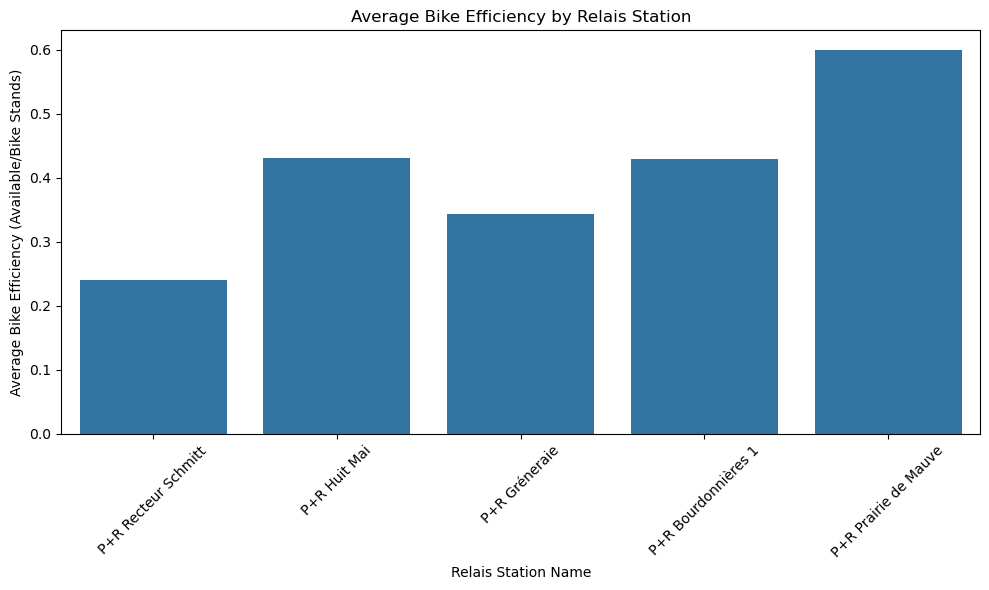

In [14]:
relays_efficiency = (
    df_relais.alias("rel")
    .join(
         df_velos.alias("velo"),
         (F.abs(F.col("rel.location.lon") - F.col("velo.position.lon")) <= 0.01) &
         (F.abs(F.col("rel.location.lat") - F.col("velo.position.lat")) <= 0.01)
    )
    .withColumn("bike_efficiency", F.col("velo.available_bikes") / F.col("velo.bike_stands"))
    .groupBy("rel.grp_nom")
    .agg(F.avg("bike_efficiency").alias("avg_bike_efficiency"))
)

# Convert to Pandas for plotting
relays_efficiency_pd = relays_efficiency.toPandas()

# Example visualization using seaborn and matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=relays_efficiency_pd, x="grp_nom", y="avg_bike_efficiency")
plt.title("Average Bike Efficiency by Relais Station")
plt.xlabel("Relais Station Name")
plt.ylabel("Average Bike Efficiency (Available/Bike Stands)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [15]:
# Register DataFrames as temporary views if not already registered
df_parking.createOrReplaceTempView("parking")
df_velos.createOrReplaceTempView("velos")

# Execute the SparkSQL query
result = spark.sql("""
SELECT 
    p.grp_identifiant,
    p.grp_nom,
    COUNT(DISTINCT v.number) AS nearby_bike_stations,
    AVG(v.available_bikes) AS avg_available_bikes
FROM parking p
JOIN velos v
  ON ABS(p.location.lon - v.position.lon) <= 0.01
     AND ABS(p.location.lat - v.position.lat) <= 0.01
WHERE p.grp_complet <> 1
GROUP BY p.grp_identifiant, p.grp_nom
ORDER BY avg_available_bikes DESC
""")

# Display the results
result.show(truncate=False)


25/02/19 18:46:48 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 18:46:49 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+---------------+----------------------+--------------------+-------------------+
|grp_identifiant|grp_nom               |nearby_bike_stations|avg_available_bikes|
+---------------+----------------------+--------------------+-------------------+
|044            |Gare Sud 2            |17                  |10.733031674208144 |
|010            |Cathédrale            |41                  |9.169407894736842  |
|034            |Gare Sud 4            |23                  |8.960526315789474  |
|012            |Descartes             |35                  |8.664804469273744  |
|004            |Graslin               |40                  |8.499176276771005  |
|037            |Gloriette 2           |37                  |8.432188065099458  |
|027            |Gare Sud 3            |25                  |8.405882352941177  |
|029            |Bellamy               |35                  |8.391465677179962  |
|035            |Baco-LU 1             |41                  |8.371475953565506  |
|001            

In [ ]:
# Read velos as streaming and relais as static
df_velos_stream = read_kafka_stream(velos_topic, schema_velos, is_streaming=True)
df_relais_static = read_kafka_stream(relais_topic, schema_relais, is_streaming=False)

# Perform the join using the spatial condition
streaming_velos_relais = (
    df_velos_stream.alias("velo")
    .join(
         df_relais_static.alias("rel"),
         (F.abs(F.col("velo.position.lon") - F.col("rel.location.lon")) <= 0.01) &
         (F.abs(F.col("velo.position.lat") - F.col("rel.location.lat")) <= 0.01)
    )
    .select(
         F.col("rel.grp_identifiant").alias("relais_id"),
         F.col("rel.grp_nom").alias("relais_name"),
         F.col("velo.number").alias("velo_station"),
         F.col("velo.available_bikes")
    )
)

streaming_velos_relais.writeStream \
    .outputMode("append") \
    .format("console") \
    .start()


25/02/19 19:14:42 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-96a1f6cb-6c08-4919-bea6-b77f72d5d46c. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/02/19 19:14:42 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


25/02/19 19:14:42 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:14:42 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:14:42 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:14:42 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


-------------------------------------------
Batch: 0
-------------------------------------------
+---------+-------------+------------+---------------+
|relais_id|  relais_name|velo_station|available_bikes|
+---------+-------------+------------+---------------+
|      144|P+R Gréneraie|          56|              1|
|      144|P+R Gréneraie|          56|              1|
|      144|P+R Gréneraie|          56|              1|
|      144|P+R Gréneraie|          56|              1|
|      144|P+R Gréneraie|          56|              1|
|      144|P+R Gréneraie|          56|              1|
|      144|P+R Gréneraie|          56|              1|
|      140| P+R Huit Mai|        1011|              0|
|      140| P+R Huit Mai|        1011|              0|
|      140| P+R Huit Mai|        1011|              0|
|      140| P+R Huit Mai|        1011|              0|
|      140| P+R Huit Mai|        1011|              0|
|      140| P+R Huit Mai|        1011|              0|
|      140| P+R Huit Ma

25/02/19 19:15:09 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:15:09 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:15:09 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:15:09 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:15:09 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:15:

-------------------------------------------
Batch: 3
-------------------------------------------
+---------+-----------+------------+---------------+
|relais_id|relais_name|velo_station|available_bikes|
+---------+-----------+------------+---------------+
+---------+-----------+------------+---------------+



25/02/19 19:15:13 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:15:13 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:15:13 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


-------------------------------------------
Batch: 1
-------------------------------------------
+---------+-----------+------------+---------------+
|relais_id|relais_name|velo_station|available_bikes|
+---------+-----------+------------+---------------+
+---------+-----------+------------+---------------+



25/02/19 19:15:15 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:15:15 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:15:15 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


-------------------------------------------
Batch: 3
-------------------------------------------
+---------+-----------+------------+---------------+
|relais_id|relais_name|velo_station|available_bikes|
+---------+-----------+------------+---------------+
+---------+-----------+------------+---------------+



-------------------------------------------
Batch: 4
-------------------------------------------
+---------+-------------+------------+---------------+
|relais_id|  relais_name|velo_station|available_bikes|
+---------+-------------+------------+---------------+
|      140| P+R Huit Mai|         102|             21|
|      140| P+R Huit Mai|         102|             21|
|      140| P+R Huit Mai|         102|             21|
|      140| P+R Huit Mai|         102|             21|
|      140| P+R Huit Mai|         102|             21|
|      140| P+R Huit Mai|         102|             21|
|      140| P+R Huit Mai|         102|             21|
|      140| P+R Huit Mai|         102|             21|
|      140| P+R Huit Mai|         102|             21|
|      140| P+R Huit Mai|         102|             21|
|      140| P+R Huit Mai|         102|             21|
|      140| P+R Huit Mai|         102|             21|
|      144|P+R Gréneraie|          57|              1|
|      144|P+R Grénerai

-------------------------------------------
Batch: 2
-------------------------------------------
+---------+-------------+------------+---------------+
|relais_id|  relais_name|velo_station|available_bikes|
+---------+-------------+------------+---------------+
|      140| P+R Huit Mai|         102|             21|
|      140| P+R Huit Mai|         102|             21|
|      140| P+R Huit Mai|         102|             21|
|      140| P+R Huit Mai|         102|             21|
|      140| P+R Huit Mai|         102|             21|
|      140| P+R Huit Mai|         102|             21|
|      140| P+R Huit Mai|         102|             21|
|      140| P+R Huit Mai|         102|             21|
|      140| P+R Huit Mai|         102|             21|
|      140| P+R Huit Mai|         102|             21|
|      140| P+R Huit Mai|         102|             21|
|      140| P+R Huit Mai|         102|             21|
|      144|P+R Gréneraie|          57|              1|
|      144|P+R Grénerai

-------------------------------------------
Batch: 4
-------------------------------------------
+---------+-------------+------------+---------------+
|relais_id|  relais_name|velo_station|available_bikes|
+---------+-------------+------------+---------------+
|      140| P+R Huit Mai|         102|             21|
|      140| P+R Huit Mai|         102|             21|
|      140| P+R Huit Mai|         102|             21|
|      140| P+R Huit Mai|         102|             21|
|      140| P+R Huit Mai|         102|             21|
|      140| P+R Huit Mai|         102|             21|
|      140| P+R Huit Mai|         102|             21|
|      140| P+R Huit Mai|         102|             21|
|      140| P+R Huit Mai|         102|             21|
|      140| P+R Huit Mai|         102|             21|
|      140| P+R Huit Mai|         102|             21|
|      140| P+R Huit Mai|         102|             21|
|      144|P+R Gréneraie|          57|              1|
|      144|P+R Grénerai

25/02/19 19:16:21 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:16:21 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:16:21 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:16:21 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:16:21 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:16:

-------------------------------------------
Batch: 5
-------------------------------------------
+---------+------------+------------+---------------+
|relais_id| relais_name|velo_station|available_bikes|
+---------+------------+------------+---------------+
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1012|  

25/02/19 19:16:24 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:16:26 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:16:26 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


-------------------------------------------
Batch: 3
-------------------------------------------
+---------+------------+------------+---------------+
|relais_id| relais_name|velo_station|available_bikes|
+---------+------------+------------+---------------+
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1012|  

25/02/19 19:16:26 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:16:28 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:16:28 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


-------------------------------------------
Batch: 5
-------------------------------------------
+---------+------------+------------+---------------+
|relais_id| relais_name|velo_station|available_bikes|
+---------+------------+------------+---------------+
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1012|  

25/02/19 19:16:28 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


-------------------------------------------
Batch: 6
-------------------------------------------
+---------+-------------+------------+---------------+
|relais_id|  relais_name|velo_station|available_bikes|
+---------+-------------+------------+---------------+
|      144|P+R Gréneraie|          56|              1|
|      144|P+R Gréneraie|          56|              1|
|      144|P+R Gréneraie|          56|              1|
|      144|P+R Gréneraie|          56|              1|
|      144|P+R Gréneraie|          56|              1|
|      144|P+R Gréneraie|          56|              1|
|      144|P+R Gréneraie|          56|              1|
|      144|P+R Gréneraie|          56|              1|
|      144|P+R Gréneraie|          83|              7|
|      144|P+R Gréneraie|          83|              7|
|      144|P+R Gréneraie|          83|              7|
|      144|P+R Gréneraie|          83|              7|
|      144|P+R Gréneraie|          83|              7|
|      144|P+R Grénerai

In [ ]:
# Add a constant column to both streaming DataFrames
df_velos_stream = read_kafka_stream(velos_topic, schema_velos, is_streaming=True).withColumn("dummy", F.lit(1))
df_relais_stream = read_kafka_stream(relais_topic, schema_relais, is_streaming=True).withColumn("dummy", F.lit(1))

streaming_velos_relais = (
    df_velos_stream.alias("velo")
    .join(
         df_relais_stream.alias("rel"),
         on="dummy"  # This is the required equality predicate
    )
    .filter(
         (F.abs(F.col("velo.position.lon") - F.col("rel.location.lon")) <= 0.01) &
         (F.abs(F.col("velo.position.lat") - F.col("rel.location.lat")) <= 0.01)
    )
    .select(
         F.col("rel.grp_identifiant").alias("relais_id"),
         F.col("rel.grp_nom").alias("relais_name"),
         F.col("velo.number").alias("velo_station"),
         F.col("velo.available_bikes")
    )
)

streaming_velos_relais.writeStream \
    .outputMode("append") \
    .format("console") \
    .start()


-------------------------------------------
Batch: 4
-------------------------------------------
+---------+-------------+------------+---------------+
|relais_id|  relais_name|velo_station|available_bikes|
+---------+-------------+------------+---------------+
|      144|P+R Gréneraie|          56|              1|
|      144|P+R Gréneraie|          56|              1|
|      144|P+R Gréneraie|          56|              1|
|      144|P+R Gréneraie|          56|              1|
|      144|P+R Gréneraie|          56|              1|
|      144|P+R Gréneraie|          56|              1|
|      144|P+R Gréneraie|          56|              1|
|      144|P+R Gréneraie|          56|              1|
|      144|P+R Gréneraie|          83|              7|
|      144|P+R Gréneraie|          83|              7|
|      144|P+R Gréneraie|          83|              7|
|      144|P+R Gréneraie|          83|              7|
|      144|P+R Gréneraie|          83|              7|
|      144|P+R Grénerai

25/02/19 19:16:30 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-f23a9a15-68c1-4aa3-a638-39f8624acb71. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/02/19 19:16:30 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


25/02/19 19:16:30 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:16:30 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


-------------------------------------------
Batch: 6
-------------------------------------------
+---------+-------------+------------+---------------+
|relais_id|  relais_name|velo_station|available_bikes|
+---------+-------------+------------+---------------+
|      144|P+R Gréneraie|          56|              1|
|      144|P+R Gréneraie|          56|              1|
|      144|P+R Gréneraie|          56|              1|
|      144|P+R Gréneraie|          56|              1|
|      144|P+R Gréneraie|          56|              1|
|      144|P+R Gréneraie|          56|              1|
|      144|P+R Gréneraie|          56|              1|
|      144|P+R Gréneraie|          56|              1|
|      144|P+R Gréneraie|          83|              7|
|      144|P+R Gréneraie|          83|              7|
|      144|P+R Gréneraie|          83|              7|
|      144|P+R Gréneraie|          83|              7|
|      144|P+R Gréneraie|          83|              7|
|      144|P+R Grénerai

-------------------------------------------
Batch: 0
-------------------------------------------
+---------+--------------------+------------+---------------+
|relais_id|         relais_name|velo_station|available_bikes|
+---------+--------------------+------------+---------------+
|      147| P+R Bourdonnières 1|         109|              9|
|      147| P+R Bourdonnières 1|         109|              9|
|      147| P+R Bourdonnières 1|         109|              9|
|      147| P+R Bourdonnières 1|         109|              9|
|      147| P+R Bourdonnières 1|         109|              9|
|      147| P+R Bourdonnières 1|         109|              9|
|      147| P+R Bourdonnières 1|         109|              9|
|      147| P+R Bourdonnières 1|         109|              8|
|      147| P+R Bourdonnières 1|         109|              9|
|      147| P+R Bourdonnières 1|         109|              9|
|      147| P+R Bourdonnières 1|         109|              9|
|      147| P+R Bourdonnières 1|   

25/02/19 19:17:23 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:17:23 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:17:23 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:17:23 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:17:23 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:17:

-------------------------------------------
Batch: 1
-------------------------------------------
+---------+-------------------+------------+---------------+
|relais_id|        relais_name|velo_station|available_bikes|
+---------+-------------------+------------+---------------+
|      139|P+R Recteur Schmitt|          94|              8|
|      139|P+R Recteur Schmitt|          93|              5|
|      139|P+R Recteur Schmitt|          94|              8|
|      139|P+R Recteur Schmitt|          93|              5|
|      139|P+R Recteur Schmitt|          94|              8|
|      139|P+R Recteur Schmitt|          94|              8|
|      139|P+R Recteur Schmitt|          93|              5|
|      139|P+R Recteur Schmitt|          93|              5|
|      139|P+R Recteur Schmitt|          94|              8|
|      139|P+R Recteur Schmitt|          93|              5|
|      139|P+R Recteur Schmitt|          94|              8|
|      139|P+R Recteur Schmitt|          93|     

25/02/19 19:17:26 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:17:26 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


-------------------------------------------
Batch: 5
-------------------------------------------
+---------+------------+------------+---------------+
|relais_id| relais_name|velo_station|available_bikes|
+---------+------------+------------+---------------+
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|  

25/02/19 19:17:26 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:17:28 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:17:28 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


-------------------------------------------
Batch: 7
-------------------------------------------
+---------+------------+------------+---------------+
|relais_id| relais_name|velo_station|available_bikes|
+---------+------------+------------+---------------+
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|  

25/02/19 19:17:28 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:17:30 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:17:30 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


-------------------------------------------
Batch: 7
-------------------------------------------
+---------+------------+------------+---------------+
|relais_id| relais_name|velo_station|available_bikes|
+---------+------------+------------+---------------+
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|  

25/02/19 19:17:30 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


-------------------------------------------
Batch: 2
-------------------------------------------
+---------+------------+------------+---------------+
|relais_id| relais_name|velo_station|available_bikes|
+---------+------------+------------+---------------+
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|  

-------------------------------------------
Batch: 6
-------------------------------------------
+---------+-------------+------------+---------------+
|relais_id|  relais_name|velo_station|available_bikes|
+---------+-------------+------------+---------------+
|      140| P+R Huit Mai|         101|             14|
|      140| P+R Huit Mai|         101|             14|
|      140| P+R Huit Mai|         101|             14|
|      144|P+R Gréneraie|         101|             14|
|      140| P+R Huit Mai|         101|             14|
|      144|P+R Gréneraie|         101|             14|
|      144|P+R Gréneraie|         101|             14|
|      140| P+R Huit Mai|         101|             14|
|      140| P+R Huit Mai|         101|             14|
|      144|P+R Gréneraie|         101|             14|
|      140| P+R Huit Mai|         101|             14|
|      144|P+R Gréneraie|         101|             14|
|      140| P+R Huit Mai|         101|             14|
|      140| P+R Huit Ma

-------------------------------------------
Batch: 8
-------------------------------------------
+---------+-------------+------------+---------------+
|relais_id|  relais_name|velo_station|available_bikes|
+---------+-------------+------------+---------------+
|      140| P+R Huit Mai|         101|             14|
|      140| P+R Huit Mai|         101|             14|
|      140| P+R Huit Mai|         101|             14|
|      144|P+R Gréneraie|         101|             14|
|      140| P+R Huit Mai|         101|             14|
|      144|P+R Gréneraie|         101|             14|
|      144|P+R Gréneraie|         101|             14|
|      140| P+R Huit Mai|         101|             14|
|      140| P+R Huit Mai|         101|             14|
|      144|P+R Gréneraie|         101|             14|
|      140| P+R Huit Mai|         101|             14|
|      144|P+R Gréneraie|         101|             14|
|      140| P+R Huit Mai|         101|             14|
|      140| P+R Huit Ma

-------------------------------------------
Batch: 8
-------------------------------------------
+---------+-------------+------------+---------------+
|relais_id|  relais_name|velo_station|available_bikes|
+---------+-------------+------------+---------------+
|      140| P+R Huit Mai|         101|             14|
|      140| P+R Huit Mai|         101|             14|
|      140| P+R Huit Mai|         101|             14|
|      144|P+R Gréneraie|         101|             14|
|      140| P+R Huit Mai|         101|             14|
|      144|P+R Gréneraie|         101|             14|
|      144|P+R Gréneraie|         101|             14|
|      140| P+R Huit Mai|         101|             14|
|      140| P+R Huit Mai|         101|             14|
|      144|P+R Gréneraie|         101|             14|
|      140| P+R Huit Mai|         101|             14|
|      144|P+R Gréneraie|         101|             14|
|      140| P+R Huit Mai|         101|             14|
|      140| P+R Huit Ma

25/02/19 19:18:24 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:18:24 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:18:24 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:18:24 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:18:24 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:18:

-------------------------------------------
Batch: 7
-------------------------------------------
+---------+------------+------------+---------------+
|relais_id| relais_name|velo_station|available_bikes|
+---------+------------+------------+---------------+
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|  

-------------------------------------------
Batch: 3
-------------------------------------------
+---------+-------------------+------------+---------------+
|relais_id|        relais_name|velo_station|available_bikes|
+---------+-------------------+------------+---------------+
|      139|P+R Recteur Schmitt|          94|              8|
|      139|P+R Recteur Schmitt|          93|              5|
|      139|P+R Recteur Schmitt|          94|              8|
|      139|P+R Recteur Schmitt|          93|              5|
|      139|P+R Recteur Schmitt|          94|              8|
|      139|P+R Recteur Schmitt|          94|              8|
|      139|P+R Recteur Schmitt|          93|              5|
|      139|P+R Recteur Schmitt|          93|              5|
|      139|P+R Recteur Schmitt|          94|              8|
|      139|P+R Recteur Schmitt|          93|              5|
|      139|P+R Recteur Schmitt|          94|              8|
|      139|P+R Recteur Schmitt|          93|     

25/02/19 19:18:27 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:18:27 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:18:27 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


-------------------------------------------
Batch: 9
-------------------------------------------
+---------+------------+------------+---------------+
|relais_id| relais_name|velo_station|available_bikes|
+---------+------------+------------+---------------+
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|  

25/02/19 19:18:28 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:18:28 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:18:28 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


-------------------------------------------
Batch: 9
-------------------------------------------
+---------+------------+------------+---------------+
|relais_id| relais_name|velo_station|available_bikes|
+---------+------------+------------+---------------+
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|  

-------------------------------------------
Batch: 8
-------------------------------------------
+---------+-------------------+------------+---------------+
|relais_id|        relais_name|velo_station|available_bikes|
+---------+-------------------+------------+---------------+
|      140|       P+R Huit Mai|         110|              8|
|      140|       P+R Huit Mai|         110|              8|
|      140|       P+R Huit Mai|         110|              8|
|      140|       P+R Huit Mai|         110|              8|
|      140|       P+R Huit Mai|         110|              8|
|      140|       P+R Huit Mai|         110|              8|
|      140|       P+R Huit Mai|         110|              8|
|      140|       P+R Huit Mai|         110|              8|
|      140|       P+R Huit Mai|         110|              8|
|      140|       P+R Huit Mai|         110|              8|
|      140|       P+R Huit Mai|         110|              8|
|      140|       P+R Huit Mai|         110|     

-------------------------------------------
Batch: 4
-------------------------------------------
+---------+------------+------------+---------------+
|relais_id| relais_name|velo_station|available_bikes|
+---------+------------+------------+---------------+
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|  

-------------------------------------------
Batch: 10
-------------------------------------------
+---------+-------------------+------------+---------------+
|relais_id|        relais_name|velo_station|available_bikes|
+---------+-------------------+------------+---------------+
|      140|       P+R Huit Mai|         110|              8|
|      140|       P+R Huit Mai|         110|              8|
|      140|       P+R Huit Mai|         110|              8|
|      140|       P+R Huit Mai|         110|              8|
|      140|       P+R Huit Mai|         110|              8|
|      140|       P+R Huit Mai|         110|              8|
|      140|       P+R Huit Mai|         110|              8|
|      140|       P+R Huit Mai|         110|              8|
|      140|       P+R Huit Mai|         110|              8|
|      140|       P+R Huit Mai|         110|              8|
|      140|       P+R Huit Mai|         110|              8|
|      140|       P+R Huit Mai|         110|    

-------------------------------------------
Batch: 10
-------------------------------------------
+---------+-------------------+------------+---------------+
|relais_id|        relais_name|velo_station|available_bikes|
+---------+-------------------+------------+---------------+
|      140|       P+R Huit Mai|         110|              8|
|      140|       P+R Huit Mai|         110|              8|
|      140|       P+R Huit Mai|         110|              8|
|      140|       P+R Huit Mai|         110|              8|
|      140|       P+R Huit Mai|         110|              8|
|      140|       P+R Huit Mai|         110|              8|
|      140|       P+R Huit Mai|         110|              8|
|      140|       P+R Huit Mai|         110|              8|
|      140|       P+R Huit Mai|         110|              8|
|      140|       P+R Huit Mai|         110|              8|
|      140|       P+R Huit Mai|         110|              8|
|      140|       P+R Huit Mai|         110|    

25/02/19 19:25:46 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:25:46 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:25:46 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:25:46 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:25:46 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:25:

-------------------------------------------
Batch: 9
-------------------------------------------
+---------+-----------+------------+---------------+
|relais_id|relais_name|velo_station|available_bikes|
+---------+-----------+------------+---------------+
+---------+-----------+------------+---------------+



-------------------------------------------
Batch: 5
-------------------------------------------
+---------+-------------+------------+---------------+
|relais_id|  relais_name|velo_station|available_bikes|
+---------+-------------+------------+---------------+
|      144|P+R Gréneraie|          56|              1|
|      144|P+R Gréneraie|         101|             16|
|      144|P+R Gréneraie|          82|              3|
|      144|P+R Gréneraie|          56|              1|
|      144|P+R Gréneraie|         101|             16|
|      144|P+R Gréneraie|          57|              6|
|      144|P+R Gréneraie|          56|              1|
|      144|P+R Gréneraie|         101|             16|
|      144|P+R Gréneraie|          57|              6|
|      144|P+R Gréneraie|          82|              3|
|      144|P+R Gréneraie|          99|             10|
|      144|P+R Gréneraie|         109|              9|
|      144|P+R Gréneraie|          58|              2|
|      144|P+R Grénerai

25/02/19 19:25:49 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:25:49 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:25:49 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


-------------------------------------------
Batch: 11
-------------------------------------------
+---------+-----------+------------+---------------+
|relais_id|relais_name|velo_station|available_bikes|
+---------+-----------+------------+---------------+
+---------+-----------+------------+---------------+



25/02/19 19:25:50 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:25:50 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:25:50 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


-------------------------------------------
Batch: 11
-------------------------------------------
+---------+-----------+------------+---------------+
|relais_id|relais_name|velo_station|available_bikes|
+---------+-----------+------------+---------------+
+---------+-----------+------------+---------------+



-------------------------------------------
Batch: 10
-------------------------------------------
+---------+------------+------------+---------------+
|relais_id| relais_name|velo_station|available_bikes|
+---------+------------+------------+---------------+
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011| 

-------------------------------------------
Batch: 6
-------------------------------------------
+---------+------------+------------+---------------+
|relais_id| relais_name|velo_station|available_bikes|
+---------+------------+------------+---------------+
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|  

-------------------------------------------
Batch: 12
-------------------------------------------
+---------+------------+------------+---------------+
|relais_id| relais_name|velo_station|available_bikes|
+---------+------------+------------+---------------+
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011| 

-------------------------------------------
Batch: 12
-------------------------------------------
+---------+------------+------------+---------------+
|relais_id| relais_name|velo_station|available_bikes|
+---------+------------+------------+---------------+
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011|              0|
|      140|P+R Huit Mai|        1011| 

In [ ]:
# Read streaming velos data and use static parking data
df_velos_stream = read_kafka_stream(velos_topic, schema_velos, is_streaming=True)
df_parking_static = read_kafka_stream("parking_public", schema_parking_public, is_streaming=False)

# Aggregate the streaming velos data using a time window and watermark
velos_windowed = (
    df_velos_stream
    .withColumn("event_time", F.col("last_update").cast("timestamp"))
    .withWatermark("event_time", "5 minutes")
    .groupBy(
         F.window("event_time", "10 minutes"),
         "contract_name"
    )
    .agg(
         F.avg("available_bikes").alias("avg_available_bikes"),
         F.avg("position.lon").alias("avg_lon"),
         F.avg("position.lat").alias("avg_lat"),
         F.count("number").alias("event_count")
    )
)

# Join the windowed streaming data with the static parking data
aggregated_with_parking = (
    velos_windowed.alias("vel")
    .join(
         df_parking_static.alias("parking"),
         (F.abs(F.col("vel.avg_lon") - F.col("parking.location.lon")) <= 0.01) &
         (F.abs(F.col("vel.avg_lat") - F.col("parking.location.lat")) <= 0.01)
    )
    .select(
         "window",
         "contract_name",
         "avg_available_bikes",
         "event_count",
         F.col("parking.grp_nom").alias("parking_name")
    )
)

# Write the streaming output to the console
aggregated_with_parking.writeStream \
    .outputMode("update") \
    .format("console") \
    .start()


25/02/19 19:26:05 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-0b5a2295-7bb7-40fd-81c6-50eeb29966ce. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/02/19 19:26:05 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


25/02/19 19:26:05 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:26:05 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:26:05 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:26:05 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:26:12 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:26:

-------------------------------------------
Batch: 0
-------------------------------------------
+--------------------+-------------+-------------------+-----------+------------+
|              window|contract_name|avg_available_bikes|event_count|parking_name|
+--------------------+-------------+-------------------+-----------+------------+
|{2024-05-03 10:00...|       nantes|                0.0|         26|    Les Nefs|
|{2024-05-03 10:00...|       nantes|                0.0|         26|    Les Nefs|
|{2024-05-03 10:00...|       nantes|                0.0|         26|    Les Nefs|
|{2024-05-03 10:00...|       nantes|                0.0|         26|    Les Nefs|
|{2024-05-03 10:00...|       nantes|                0.0|         26|    Les Nefs|
|{2024-05-03 10:00...|       nantes|                0.0|         26|    Les Nefs|
|{2024-05-03 10:00...|       nantes|                0.0|         26|    Les Nefs|
|{2024-05-03 10:00...|       nantes|                0.0|         26|    Les Nefs|
|

25/02/19 19:26:13 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


-------------------------------------------
Batch: 1
-------------------------------------------
+------+-------------+-------------------+-----------+------------+
|window|contract_name|avg_available_bikes|event_count|parking_name|
+------+-------------+-------------------+-----------+------------+
+------+-------------+-------------------+-----------+------------+



25/02/19 19:26:47 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:26:47 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:26:47 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:26:47 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:26:47 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:26:

-------------------------------------------
Batch: 7
-------------------------------------------
+---------+-----------+------------+---------------+
|relais_id|relais_name|velo_station|available_bikes|
+---------+-----------+------------+---------------+
+---------+-----------+------------+---------------+



25/02/19 19:26:50 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:26:50 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:26:50 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


-------------------------------------------
Batch: 13
-------------------------------------------
+---------+-----------+------------+---------------+
|relais_id|relais_name|velo_station|available_bikes|
+---------+-----------+------------+---------------+
+---------+-----------+------------+---------------+



25/02/19 19:26:52 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:26:52 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:26:52 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


-------------------------------------------
Batch: 11
-------------------------------------------
+---------+-----------+------------+---------------+
|relais_id|relais_name|velo_station|available_bikes|
+---------+-----------+------------+---------------+
+---------+-----------+------------+---------------+



25/02/19 19:26:54 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:26:54 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:26:54 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


-------------------------------------------
Batch: 13
-------------------------------------------
+---------+-----------+------------+---------------+
|relais_id|relais_name|velo_station|available_bikes|
+---------+-----------+------------+---------------+
+---------+-----------+------------+---------------+



25/02/19 19:27:01 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:27:01 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/19 19:27:01 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


-------------------------------------------
Batch: 2
-------------------------------------------
+--------------------+-------------+-------------------+-----------+---------------+
|              window|contract_name|avg_available_bikes|event_count|   parking_name|
+--------------------+-------------+-------------------+-----------+---------------+
|{2025-02-19 19:10...|       nantes|  8.891975308641975|        324|  Tour Bretagne|
|{2025-02-19 19:10...|       nantes|  8.891975308641975|        324|    Médiathèque|
|{2025-02-19 19:10...|       nantes|  8.891975308641975|        324|   Les machines|
|{2025-02-19 19:10...|       nantes|  8.891975308641975|        324|          CHU 1|
|{2025-02-19 19:10...|       nantes|  8.891975308641975|        324|          CHU 2|
|{2025-02-19 19:10...|       nantes|  8.891975308641975|        324|  Decré-Bouffay|
|{2025-02-19 19:10...|       nantes|  8.891975308641975|        324|     Hôtel Dieu|
|{2025-02-19 19:10...|       nantes|  8.8919753086419

-------------------------------------------
Batch: 8
-------------------------------------------
+---------+-------------------+------------+---------------+
|relais_id|        relais_name|velo_station|available_bikes|
+---------+-------------------+------------+---------------+
|      139|P+R Recteur Schmitt|          93|              5|
|      139|P+R Recteur Schmitt|          93|              5|
|      139|P+R Recteur Schmitt|          93|              5|
|      139|P+R Recteur Schmitt|          93|              5|
|      139|P+R Recteur Schmitt|          93|              5|
|      139|P+R Recteur Schmitt|          93|              5|
|      139|P+R Recteur Schmitt|          93|              5|
|      139|P+R Recteur Schmitt|          93|              5|
|      139|P+R Recteur Schmitt|          93|              5|
|      139|P+R Recteur Schmitt|          93|              5|
|      139|P+R Recteur Schmitt|          93|              5|
|      139|P+R Recteur Schmitt|          93|     

-------------------------------------------
Batch: 12
-------------------------------------------
+---------+-------------------+------------+---------------+
|relais_id|        relais_name|velo_station|available_bikes|
+---------+-------------------+------------+---------------+
|      139|P+R Recteur Schmitt|          93|              5|
|      139|P+R Recteur Schmitt|          93|              5|
|      139|P+R Recteur Schmitt|          93|              5|
|      139|P+R Recteur Schmitt|          93|              5|
|      139|P+R Recteur Schmitt|          93|              5|
|      140|       P+R Huit Mai|         102|             19|
|      140|       P+R Huit Mai|         102|             19|
|      140|       P+R Huit Mai|         102|             19|
|      140|       P+R Huit Mai|         102|             19|
|      140|       P+R Huit Mai|         102|             19|
|      140|       P+R Huit Mai|         102|             19|
|      140|       P+R Huit Mai|         102|    

-------------------------------------------
Batch: 14
-------------------------------------------
+---------+-------------------+------------+---------------+
|relais_id|        relais_name|velo_station|available_bikes|
+---------+-------------------+------------+---------------+
|      139|P+R Recteur Schmitt|          93|              5|
|      139|P+R Recteur Schmitt|          93|              5|
|      139|P+R Recteur Schmitt|          93|              5|
|      139|P+R Recteur Schmitt|          93|              5|
|      139|P+R Recteur Schmitt|          93|              5|
|      140|       P+R Huit Mai|         102|             19|
|      140|       P+R Huit Mai|         102|             19|
|      140|       P+R Huit Mai|         102|             19|
|      140|       P+R Huit Mai|         102|             19|
|      140|       P+R Huit Mai|         102|             19|
|      140|       P+R Huit Mai|         102|             19|
|      140|       P+R Huit Mai|         102|    

In [23]:
for q in spark.streams.active:
    q.stop()

25/02/19 19:27:10 ERROR WriteToDataSourceV2Exec: Data source write support MicroBatchWrite[epoch: 3, writer: ConsoleWriter[numRows=20, truncate=true]] is aborting.
25/02/19 19:27:10 ERROR WriteToDataSourceV2Exec: Data source write support MicroBatchWrite[epoch: 3, writer: ConsoleWriter[numRows=20, truncate=true]] aborted.


25/02/19 19:27:10 WARN TaskSetManager: Lost task 16.0 in stage 139.0 (TID 408) (172.25.0.4 executor 0): TaskKilled (Stage cancelled: Job 90 cancelled part of cancelled job group a09a3eba-c81c-4dff-8c77-451977de3688)
25/02/19 19:27:10 WARN TaskSetManager: Lost task 17.0 in stage 139.0 (TID 409) (172.25.0.4 executor 0): TaskKilled (Stage cancelled: Job 90 cancelled part of cancelled job group a09a3eba-c81c-4dff-8c77-451977de3688)
